In [342]:
import pandas as pd

In [343]:
data = pd.read_excel("Decision Tree data.xlsx")

In [485]:
data.head()

,Female,Age,Total CPR duration,Mechanical compressions,BMI,Abdominal perimeter,Thorax perimeter,Heart Mass,CMR,SRD
0,0,69,41,0,31.64,98.0,100.000000,538.000000,1.464942,0
1,0,63,40,0,28.69,105.0,109.000000,504.000000,1.372362,1
2,1,63,35,0,31.25,104.0,116.000000,450.000000,1.382913,1
3,0,67,26,0,28.41,96.0,100.000000,640.000000,1.630989,0
4,0,52,33,0,41.97,134.0,102.689362,480.455779,1.260000,1


In [317]:
## Data describ
data.isna().sum()

## There are 66 missing in BMI 7 in AP,12 TP, 1 in heart mass value

Caso                        0
Female                      0
Age                         0
Total CPR duration          0
Mechanical compressions     0
BMI                        66
Abdominal perimeter         7
Thorax perimeter           12
Heart Mass                  1
CMR                         0
SRD                         0
dtype: int64

### VIF analysis

To measure the multicollinearity among the variables

In [318]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

In [319]:
## dropping Na value
data_vif = data[~data.isin([np.nan,np.inf,-np.inf]).any(1)]

In [320]:
data_vif.drop(["Caso","SRD"],axis=1,inplace=True)

C:\Users\saurav\AppData\Local\Temp\ipykernel_20104\2681920910.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_vif.drop(["Caso","SRD"],axis=1,inplace=True)


In [321]:
vif_data = pd.DataFrame()
vif_data["feature"] = data_vif.columns
vif_data["VIF"] = [variance_inflation_factor(data_vif.values, i) for i in range(len(data_vif.columns))]

In [322]:
data_vif

,Female,Age,Total CPR duration,Mechanical compressions,BMI,Abdominal perimeter,Thorax perimeter,Heart Mass,CMR
0,0,69,41,0,31.64,98.0,100.0,538.0,1.464942
1,0,63,40,0,28.69,105.0,109.0,504.0,1.372362
2,1,63,35,0,31.25,104.0,116.0,450.0,1.382913
3,0,67,26,0,28.41,96.0,100.0,640.0,1.630989
6,0,42,24,0,22.31,75.0,81.0,320.0,1.009623
...,...,...,...,...,...,...,...,...,...
129,0,55,34,1,22.86,87.0,93.0,401.0,1.172172
130,0,39,43,1,37.29,116.0,122.0,489.0,1.143565
131,0,60,18,0,25.91,99.0,113.0,343.0,0.973989
132,1,78,14,0,33.98,112.0,107.0,486.0,1.416889


In [323]:
vif_data

,feature,VIF
0,Female,3.872054
1,Age,27.157489
2,Total CPR duration,7.168389
3,Mechanical compressions,1.458211
4,BMI,122.951383
5,Abdominal perimeter,259.557769
6,Thorax perimeter,200.010646
7,Heart Mass,150.389618
8,CMR,149.696100


#### vif analysis
This shows that, most of the varibales are highly corellated, whereas in case of femalae and male
compression, data is binary so doesn´t show that much of influence.

<AxesSubplot:>

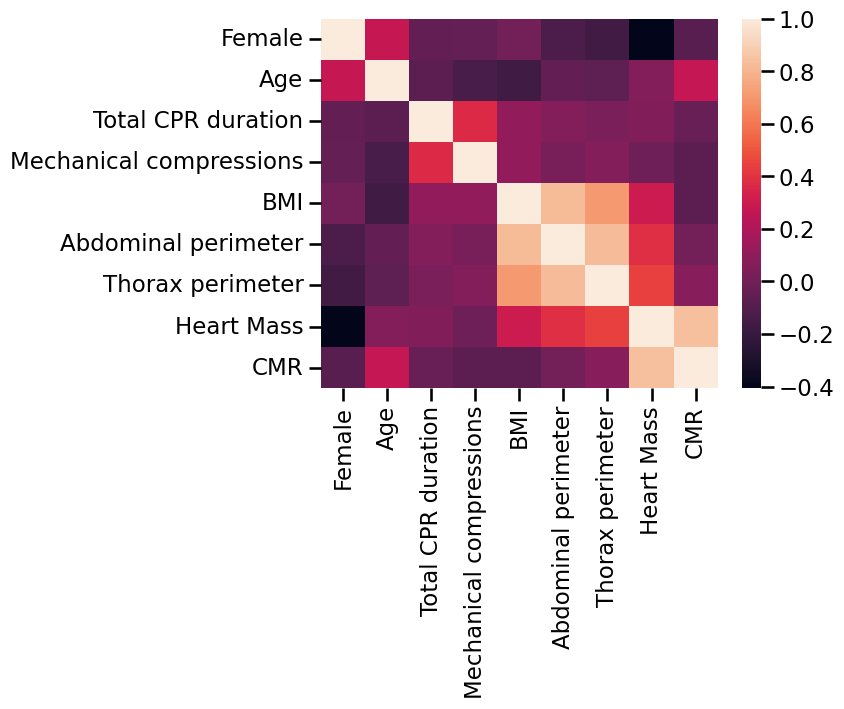

In [484]:
sns.heatmap(data_vif.corr())

### Decison tree Modellling

___


#### Clinically relevant variables
1. Age
2. Sex
3. Total CPR time
4. mechanical compressions
5. Abdominal perimeter
6. Thorax perimeter
7. Heart Mass/CMR

**Decision tree parameter**
1. Depth 4
2. Node splitting 30
3. leaf splitting 4
4. Gini impurity

In [324]:
import matplotlib.pyplot as plt
import graphviz
from collections import Counter
import seaborn as sns
import numpy as np

In [325]:
from sklearn import tree
from sklearn.tree import export_text

In [326]:
data.drop("Caso",axis=1,inplace=True)

In [327]:
data.isna().sum()

Female                      0
Age                         0
Total CPR duration          0
Mechanical compressions     0
BMI                        66
Abdominal perimeter         7
Thorax perimeter           12
Heart Mass                  1
CMR                         0
SRD                         0
dtype: int64

### Filling NA value

1. Fill the NA value with mean of the distribution.


In [331]:
### Fill the NA value
data["BMI"].fillna(data["BMI"].mean(),inplace=True)
data["Abdominal perimeter"].fillna(data["Abdominal perimeter"].mean(),inplace=True)
data["Thorax perimeter"].fillna(data["Thorax perimeter"].mean(),inplace=True)
data["Heart Mass"].fillna(data["Heart Mass"].mean(),inplace=True)

### Functions for model evaluation and plotting

#### Single Evaluation of model

In [329]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,roc_auc_score,matthews_corrcoef

def model_eval(model,x_train,x_test,y_train,y_test):
    
    """ 
    Model Eval take the model and data to return score on just one run
    ,data can be reshulled befor input
    
    """
    
    ## Accuracy
    train_accuracy = accuracy_score(model.predict(X_train),y_train)
    test_accuracy = accuracy_score(model.predict(X_test),y_test)

    ## F1 score
    train_f1 = f1_score(model.predict(X_train),y_train)
    test_f1 = f1_score(model.predict(X_test),y_test)

    ## Recall
    train_recall = recall_score(model.predict(X_train),y_train)
    test_recall = recall_score(model.predict(X_test),y_test)

    ## Precision
    train_precision = precision_score(model.predict(X_train),y_train)
    test_precision = precision_score(model.predict(X_test),y_test)

    ### ROC_AUC score
    train_roc = roc_auc_score(model.predict(X_train),y_train)
    test_roc = roc_auc_score(model.predict(X_test),y_test)

    ### mcc Score 
    train_mcc = matthews_corrcoef(model.predict(X_train),y_train)
    test_mcc = matthews_corrcoef(model.predict(X_test),y_test)


    print("Accuracy: ",train_accuracy,",",test_accuracy)
    print("F1: ",train_f1,",",test_f1)
    print("Recall: ",train_recall,",",test_recall)
    print("Precision: ",train_precision,",",test_precision)
    print("ROC: ",train_roc,",",test_roc)
    print("MCC: ",train_mcc,",",test_mcc)

#### Evaluation of model on stratified loop

In [272]:
### splitting the and training and evaluating at 5 fold
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,matthews_corrcoef,roc_auc_score


def stratifiedEvaluation(classifier,X,Y,split):
    
    """ Split the data into multiple folds, train and test the model
        on each folds, calculate the metrics as well.
    
    """
    X = np.array(X)
    Y = np.array(Y)
    
    skf = StratifiedKFold(n_splits=split,shuffle=True,random_state=44444,)

    ### Metrics container:

    ## Accuracy
    train_acc = []
    test_acc =  []

    ## F1 score
    train_F1 = []
    test_F1 =  []

    ## Recall score
    train_rec = []
    test_rec =  []

    ## Precision Score
    train_prec = []
    test_prec  = []

    ## Matthe corre_coef
    train_matt = []
    test_matt =  []

    ## roc_auc score
    train_roc_ = []
    test_roc_ = []


    for train_index, test_index in skf.split(X, Y,):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        ### Model Training
        model = clf.fit(X_train,y_train)

        ### Train and Test prediciton
        train_pred = model.predict(X_train,)
        test_pred  = model.predict(X_test,)


        ### Metrics calculation

        ### Accuracy
        train_accuracy = accuracy_score(train_pred,y_train)
        train_acc.append(train_accuracy)
        test_accuracy = accuracy_score(test_pred,y_test)
        test_acc.append(test_accuracy)

        ### F1 score
        train_f1 = f1_score(train_pred,y_train)
        train_F1.append(train_f1)
        test_f1 =  f1_score(test_pred,y_test)
        test_F1.append(test_f1)

        ### Recall_score
        train_recall = recall_score(train_pred,y_train)
        train_rec.append(train_recall)
        test_recall = recall_score(test_pred,y_test)
        test_rec.append(test_recall)

        ### Precision score
        train_precision = precision_score(train_pred,y_train)
        train_prec.append(train_precision)
        test_precision = precision_score(test_pred,y_test)
        test_prec.append(test_precision)

        ### Matthew corre_coef
        train_mcc = matthews_corrcoef(train_pred,y_train)
        train_matt.append(train_mcc)
        test_mcc =  matthews_corrcoef(test_pred,y_test)
        test_matt.append(test_mcc)

        ### ROC_auc prediction
        train_roc = roc_auc_score(train_pred,y_train)
        train_roc_.append(train_roc)
        test_roc =  roc_auc_score(test_pred,y_test)
        test_roc_.append(test_roc)

        print()

        print(f""" accuracy_train: {train_accuracy}, accuracy_test: {test_accuracy}
                   f1_train: {train_f1}, f1_test: {test_f1}
                   recall_train: {train_recall},recall_test: {test_recall}
                   precision_train: {train_precision}, precision_test: {test_precision}
                   mcc_train: {train_mcc}, mcc_test: {test_mcc}
                   roc_train : {train_roc},roc_test: {test_roc}""")
        print()


    print("Average Score---------------------------------------")
    print(f"""     accuracy_train: {np.mean(train_acc)}, accuracy_test: {np.mean(test_acc)}
                   f1_train: {np.mean(train_F1)}, f1_test: {np.mean(test_F1)}
                   recall_train: {np.mean(train_rec)},recall_test: {np.mean(test_rec)}
                   precision_train: {np.mean(train_prec)}, precision_test: {np.mean(test_prec)}
                   mcc_train: {np.mean(train_matt)}, mcc_test: {np.mean(test_matt)},
                   roc_train: {np.mean(train_roc_)}, roc_test: {np.mean(test_roc_)}""")
    
    result_dict = {"test_acc":test_acc,
                  "test_F1":test_F1,
                  "test_rec":test_rec,
                  "test_prec":test_prec,
                  "test_matt":test_matt,
                  "test_roc":test_roc_,}
    
    return result_dict

In [273]:
def MetricsPlotInput(test_acc,
                test_F1,
                test_rec,
                test_prec,
                test_matt,
                test_roc):
    """ 
    
    calculate the mean and standard deviation of all metrics
    
    """
        
    # Create lists for the plot
    metrics= ['Accuracy',
              'F1 score',
              'Recall',
              'Precision',
              'MCC',
              'ROC']

    x_pos = np.arange(len(metrics))

    CTEs = [np.mean(test_acc),
            np.mean(test_F1),
            np.mean(test_rec),
            np.mean(test_prec),
            np.mean(test_matt),
            np.mean(test_roc)]

    error = [np.std(test_acc),
             np.std(test_F1),
             np.std(test_rec),
             np.std(test_prec),
             np.std(test_matt),
             np.std(test_roc)]
    
    return {"metrics":metrics,
           "x_pos":x_pos,
           "CTEs":CTEs,
           "error":error}
    
    

In [274]:
from matplotlib.pyplot import figure

def plot(name,metrics,x_pos,CTEs,error):
    figure(figsize=(20, 30), dpi=100)
    sns.set_context("talk")
    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    
    ax.set_ylabel('Metrics Score')
    ax.set_xticks(x_pos)
    plt.xticks(rotation = 45)
    ax.set_xticklabels(metrics)
    ax.set_title('Comparision of metrics with 95% CI')
    ax.yaxis.grid(True)

    # # Save the figure and show
    plt.tight_layout()
    plt.savefig(name)
    plt.show()
    

In [275]:
## Plotting feature importance
def plotFeatureImportance(model,columns,plot_name):
    sns.set_context("poster")
    plt.figure(figsize=(35,30))
    sns.barplot([x for x in X.columns], model2.feature_importances_,)
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    plt.title("Feature importance")
    plt.savefig(plot_name,dpi=100)
    plt.show()

In [276]:
### OVERALL DATA

In [332]:
X = data.drop(["SRD"],axis=1) 
Y = pd.DataFrame(data["SRD"])

#### With Heart mass

In [216]:
X.columns

Index(['Female', 'Age', 'Total CPR duration', 'Mechanical compressions', 'BMI',
       'Abdominal perimeter', 'Thorax perimeter', 'Heart Mass', 'CMR'],
      dtype='object')

In [217]:
### Dropping CMR
X = X.drop(["CMR"],axis=1) 

In [218]:
## Building classifier with Heart mass
clf = tree.DecisionTreeClassifier(max_depth=4,
                                  criterion="gini",
                                  min_samples_split=30,
                                  min_samples_leaf=4,
                                  random_state=55)

In [219]:
scores = stratifiedEvaluation(classifier=clf,X=X,Y=Y,split=3)


 accuracy_train: 0.7293233082706767, accuracy_test: 0.5671641791044776
                   f1_train: 0.8105263157894737, f1_test: 0.7070707070707071
                   recall_train: 0.7475728155339806,recall_test: 0.625
                   precision_train: 0.8850574712643678, precision_test: 0.813953488372093
                   mcc_train: 0.363992292651441, mcc_test: -0.07901514560305704
                   roc_train : 0.7071197411003237,roc_test: 0.44886363636363635


 accuracy_train: 0.7669172932330827, accuracy_test: 0.5074626865671642
                   f1_train: 0.8248587570621468, f1_test: 0.5925925925925926
                   recall_train: 0.8021978021978022,recall_test: 0.6486486486486487
                   precision_train: 0.8488372093023255, precision_test: 0.5454545454545454
                   mcc_train: 0.4790786577050403, mcc_test: -0.01887027590177345
                   roc_train : 0.7463369963369964,roc_test: 0.490990990990991


 accuracy_train: 0.7014925373134329, accurac

In [220]:
plot_input = MetricsPlotInput(**scores)

<Figure size 2000x3000 with 0 Axes>

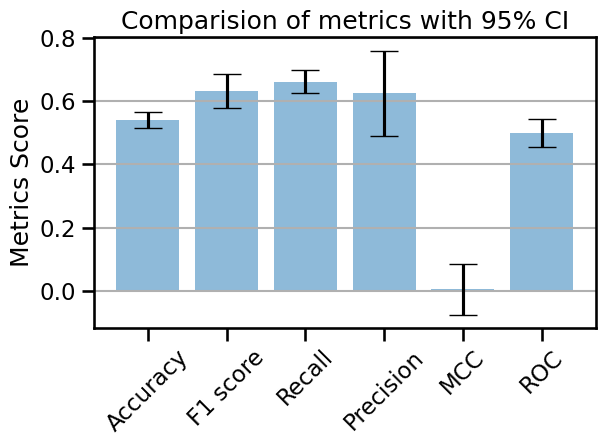

In [222]:
plot(name="test.png",**plot_input)

### WITH CMR

In [246]:
X = data.drop(["SRD"],axis=1) 
Y = pd.DataFrame(data["SRD"])

In [247]:
X.columns

Index(['Female', 'Age', 'Total CPR duration', 'Mechanical compressions', 'BMI',
       'Abdominal perimeter', 'Thorax perimeter', 'Heart Mass', 'CMR'],
      dtype='object')

In [249]:
X.drop("Heart Mass",inplace=True,axis=1)

In [252]:
## Building classifier with Heart mass
clf = tree.DecisionTreeClassifier(max_depth=4,
                                  criterion="gini",
                                  min_samples_split=30,
                                  min_samples_leaf=4,
                                  random_state=55)

In [253]:
scores = stratifiedEvaluation(classifier=clf,X=X,Y=Y,split=3)


 accuracy_train: 0.7293233082706767, accuracy_test: 0.5671641791044776
                   f1_train: 0.8105263157894737, f1_test: 0.7070707070707071
                   recall_train: 0.7475728155339806,recall_test: 0.625
                   precision_train: 0.8850574712643678, precision_test: 0.813953488372093
                   mcc_train: 0.363992292651441, mcc_test: -0.07901514560305704
                   roc_train : 0.7071197411003237,roc_test: 0.44886363636363635


 accuracy_train: 0.7819548872180451, accuracy_test: 0.4626865671641791
                   f1_train: 0.8415300546448087, f1_test: 0.5714285714285713
                   recall_train: 0.7938144329896907,recall_test: 0.6
                   precision_train: 0.8953488372093024, precision_test: 0.5454545454545454
                   mcc_train: 0.5054633747543594, mcc_test: -0.1453923157761495
                   roc_train : 0.7719072164948453,roc_test: 0.4296296296296297


 accuracy_train: 0.7313432835820896, accuracy_test: 0.60606

In [254]:
plot_input = MetricsPlotInput(**scores)

<Figure size 2000x3000 with 0 Axes>

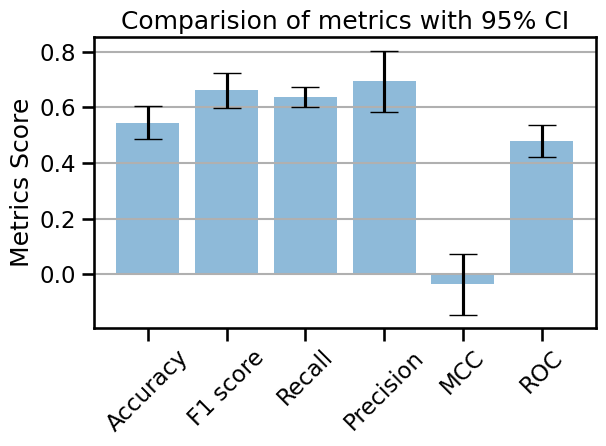

In [255]:
plot(name="metrics_with_CMR.png",**plot_input)

### WIth signifcant variable

1. Age
2. Total CPR time
3. Mechanical compression
4. Abdominal perimeter
5. Heart mass/CMR

In [304]:
X.columns

Index(['Female', 'Age', 'Total CPR duration', 'Mechanical compressions', 'BMI',
       'Abdominal perimeter', 'Thorax perimeter', 'Heart Mass', 'CMR'],
      dtype='object')

In [306]:
X = data[["Age","Total CPR duration","Mechanical compressions","Abdominal perimeter","CMR"]]
Y = pd.DataFrame(data["SRD"])

### With CMR

In [309]:
## Building classifier with Heart mass
clf = tree.DecisionTreeClassifier(max_depth=4,
                                  criterion="gini",
                                  min_samples_split=30,
                                  min_samples_leaf=4,
                                  random_state=55)

In [310]:
scores = stratifiedEvaluation(classifier=clf,X=X,Y=Y,split=3)


 accuracy_train: 0.7293233082706767, accuracy_test: 0.5671641791044776
                   f1_train: 0.8105263157894737, f1_test: 0.7070707070707071
                   recall_train: 0.7475728155339806,recall_test: 0.625
                   precision_train: 0.8850574712643678, precision_test: 0.813953488372093
                   mcc_train: 0.363992292651441, mcc_test: -0.07901514560305704
                   roc_train : 0.7071197411003237,roc_test: 0.44886363636363635


 accuracy_train: 0.7218045112781954, accuracy_test: 0.5373134328358209
                   f1_train: 0.8042328042328043, f1_test: 0.6804123711340205
                   recall_train: 0.7378640776699029,recall_test: 0.6226415094339622
                   precision_train: 0.8837209302325582, precision_test: 0.75
                   mcc_train: 0.35369801190718264, mcc_test: -0.13963463734532494
                   roc_train : 0.7022653721682849,roc_test: 0.41846361185983827


 accuracy_train: 0.7313432835820896, accuracy_test: 0.5

In [311]:
plot_input = MetricsPlotInput(**scores)

<Figure size 2000x3000 with 0 Axes>

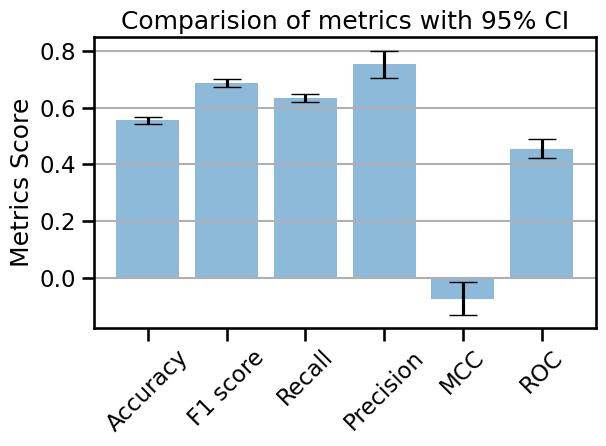

In [313]:
plot(name="metrics_with_CMR(significant).png",**plot_input)

### With Heart Mass

In [333]:
X.columns

Index(['Female', 'Age', 'Total CPR duration', 'Mechanical compressions', 'BMI',
       'Abdominal perimeter', 'Thorax perimeter', 'Heart Mass', 'CMR'],
      dtype='object')

In [335]:
X = data[["Age","Total CPR duration","Mechanical compressions","Abdominal perimeter","Heart Mass"]]
Y = pd.DataFrame(data["SRD"])

In [337]:
## Building classifier with Heart mass
clf = tree.DecisionTreeClassifier(max_depth=4,
                                  criterion="gini",
                                  min_samples_split=30,
                                  min_samples_leaf=4,
                                  random_state=55)

In [338]:
scores = stratifiedEvaluation(classifier=clf,X=X,Y=Y,split=3)


 accuracy_train: 0.7293233082706767, accuracy_test: 0.5671641791044776
                   f1_train: 0.8105263157894737, f1_test: 0.7070707070707071
                   recall_train: 0.7475728155339806,recall_test: 0.625
                   precision_train: 0.8850574712643678, precision_test: 0.813953488372093
                   mcc_train: 0.363992292651441, mcc_test: -0.07901514560305704
                   roc_train : 0.7071197411003237,roc_test: 0.44886363636363635


 accuracy_train: 0.7518796992481203, accuracy_test: 0.6417910447761194
                   f1_train: 0.8341708542713568, f1_test: 0.76
                   recall_train: 0.7345132743362832,recall_test: 0.6785714285714286
                   precision_train: 0.9651162790697675, precision_test: 0.8636363636363636
                   mcc_train: 0.43706944188622343, mcc_test: 0.1038563941617703
                   roc_train : 0.7922566371681415,roc_test: 0.5665584415584416


 accuracy_train: 0.6940298507462687, accuracy_test: 0.5303

In [339]:
plot_input = MetricsPlotInput(**scores)

<Figure size 2000x3000 with 0 Axes>

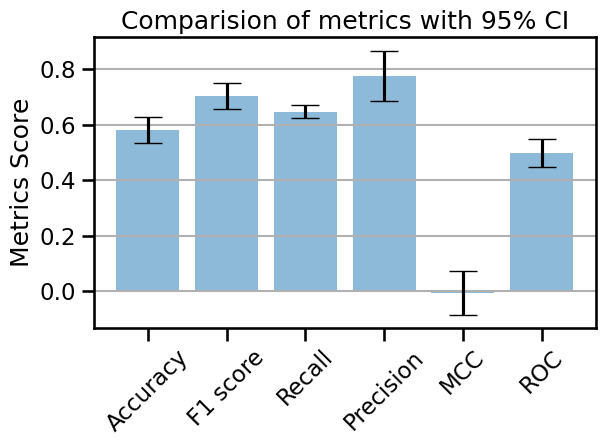

In [340]:
plot(name="metrics_with_HeartMass(significant).png",**plot_input)

### Automatic selection

In feature selection method, there are three types of methods has been used
1. Filter based (Pearson correlation,chi_square test)
2. Wrapper based (Recurive feature elimation)
3. Embedded (Lassos and RF)

In [457]:
### Pearson correlation test

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    print(str(len(cor_feature)), 'selected features')
    
    return cor_support

In [458]:
### Chi square test

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def Chi(X,y,num_feats):
    
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    
    return chi_support

In [459]:
### Recurive feature elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

def rfe(X,y,num_feats):
    rfe_selector = RFE(estimator=LogisticRegression(),
                       n_features_to_select=num_feats,
                       step=10,
                       verbose=5)
    
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    
    return rfe_support

In [460]:
## Embedded Method

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

def EmbeddedLasso(X,y,num_feats):
    
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"),
                                          max_features=num_feats)
    
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector.fit(X_norm, y)

    embeded_lr_support = embeded_lr_selector.get_support()
    
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    
    print(str(len(embeded_lr_feature)), 'selected features')
    
    return embeded_lr_support

In [461]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def EmbeddedRF(X,y,num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100),
                                          max_features=num_feats)
    embeded_rf_selector.fit(X, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

    print(str(len(embeded_rf_feature)), 'selected features')
    
    return embeded_rf_support

In [462]:
# put all selection together

def featureSelectionFrame(X,y,num_feats):
    
    feature_name = list(X.columns)
    
    cor_support = cor_selector(X,y,num_feats)
    chi_support = Chi(X,y,num_feats)
    rfe_support  = rfe(X,y,num_feats)
    embeded_lr_support = EmbeddedLasso(X,y,num_feats)
    embeded_rf_support  = EmbeddedRF(X,y,num_feats)
    
    
    assert len(cor_support) == len(chi_support) == len(rfe_support) == len(embeded_lr_support) == len(embeded_rf_support)
    
    feature_selection_df = pd.DataFrame({'Feature':feature_name, 
                                         'Pearson':cor_support, 
                                         'Chi-2':chi_support, 
                                         'RFE':rfe_support, 
                                         'Logistics':embeded_lr_support,
                                         'Random Forest':embeded_rf_support,})

    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df)+1)
    feature_selection_df.head(num_feats)
    
    return feature_selection_df
    
    

In [463]:
data = pd.read_excel("Decision Tree data.xlsx")

In [464]:
### Fill the NA value
data["BMI"].fillna(data["BMI"].mean(),inplace=True)
data["Abdominal perimeter"].fillna(data["Abdominal perimeter"].mean(),inplace=True)
data["Thorax perimeter"].fillna(data["Thorax perimeter"].mean(),inplace=True)
data["Heart Mass"].fillna(data["Heart Mass"].mean(),inplace=True)

In [465]:
data.drop("Caso",axis=1,inplace=True)

In [466]:
X = data.drop("SRD",axis=1)
Y = data["SRD"]

In [471]:
frame  = featureSelectionFrame(X=X,y=Y,num_feats=5)

5 selected features
5 selected features
Fitting estimator with 9 features.
5 selected features
4 selected features
5 selected features
9 9 9 9 9


C:\Users\saurav\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


In [472]:
frame

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,Total
1,Age,True,True,True,True,True,5
2,Abdominal perimeter,True,True,True,True,True,5
3,Mechanical compressions,True,True,True,True,False,4
4,Total CPR duration,True,True,True,False,False,3
5,Heart Mass,True,True,False,False,True,3
6,BMI,False,False,True,True,False,2
7,Thorax perimeter,False,False,False,False,True,1
8,CMR,False,False,False,False,True,1
9,Female,False,False,False,False,False,0


### Decision tree trained on automated selection feature

In [473]:
data = pd.read_excel("Decision Tree data.xlsx")

In [474]:
### Fill the NA value
data["BMI"].fillna(data["BMI"].mean(),inplace=True)
data["Abdominal perimeter"].fillna(data["Abdominal perimeter"].mean(),inplace=True)
data["Thorax perimeter"].fillna(data["Thorax perimeter"].mean(),inplace=True)
data["Heart Mass"].fillna(data["Heart Mass"].mean(),inplace=True)

In [475]:
data.drop("Caso",axis=1,inplace=True)

In [477]:
X = data[["Age","Total CPR duration","Mechanical compressions","Abdominal perimeter","Heart Mass","BMI"]]
Y = data["SRD"]

In [478]:
## Building classifier with Heart mass
clf = tree.DecisionTreeClassifier(max_depth=4,
                                  criterion="gini",
                                  min_samples_split=30,
                                  min_samples_leaf=4,
                                  random_state=55)

In [479]:
scores = stratifiedEvaluation(classifier=clf,X=X,Y=Y,split=3)


 accuracy_train: 0.7293233082706767, accuracy_test: 0.5671641791044776
                   f1_train: 0.8105263157894737, f1_test: 0.7070707070707071
                   recall_train: 0.7475728155339806,recall_test: 0.625
                   precision_train: 0.8850574712643678, precision_test: 0.813953488372093
                   mcc_train: 0.363992292651441, mcc_test: -0.07901514560305704
                   roc_train : 0.7071197411003237,roc_test: 0.44886363636363635


 accuracy_train: 0.7593984962406015, accuracy_test: 0.5522388059701493
                   f1_train: 0.8315789473684211, f1_test: 0.6808510638297872
                   recall_train: 0.7596153846153846,recall_test: 0.64
                   precision_train: 0.9186046511627907, precision_test: 0.7272727272727273
                   mcc_train: 0.4476567679720179, mcc_test: -0.06037933254944513
                   roc_train : 0.7591180371352785,roc_test: 0.46705882352941175


 accuracy_train: 0.7014925373134329, accuracy_test: 0.54

In [480]:
plot_input = MetricsPlotInput(**scores)

<Figure size 2000x3000 with 0 Axes>

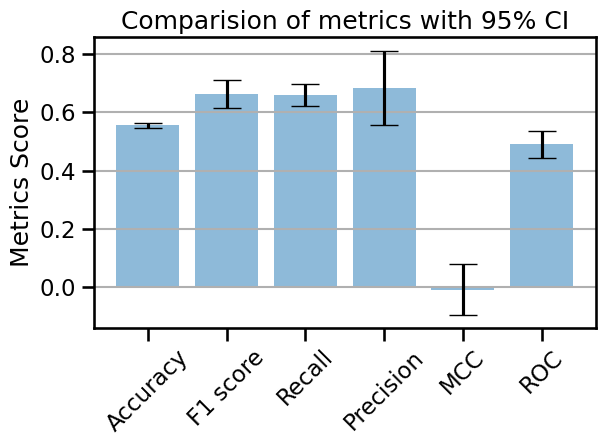

In [481]:
plot(name="Automated_features.png",**plot_input)